In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 27

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 27)                297       
Total params: 1,367
Trainable params: 1,367
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
49/92 [==============>...............] - ETA: 0s - loss: 3.2432 - accuracy: 0.0770
Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
92/92 [==============================] - 0s 2ms/step - loss: 3.1856 - accuracy: 0.0992 - val_loss: 3.0048 - val_accuracy: 0.1673
Epoch 2/1000
48/92 [==============>...............] - ETA: 0s - loss: 2.9954 - accuracy: 0.1442
Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
92/92 [==============================] - 0s 1ms/step - loss: 2.9534 - accuracy: 0.1525 - val_loss: 2.7948 - val_accuracy: 0.1884
Epoch 3/1000
49/92 [==============>...............] - ETA: 0s - loss: 2.8483 - accuracy: 0.1590
Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
92/92 [==============================] - 0s 2ms/step - loss: 2.8127 - accuracy: 0.1643 - val_loss: 2.6266 - val_accuracy: 0.2135
Epoch 4/1000
79/92 [========================>.....] - ETA: 0s - loss: 2.6915 - accura

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

31/31 [==============================] - 0s 678us/step - loss: 1.0082 - accuracy: 0.7770


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[9.43264109e-04 3.28958011e-03 1.71061931e-03 9.53575596e-02
 1.10778816e-01 6.49232194e-02 4.95099521e-04 1.42674997e-01
 3.86982465e-05 1.56217609e-02 4.09062356e-02 8.05984484e-04
 1.83295720e-04 1.39427336e-03 1.17687485e-03 4.61270809e-01
 5.79857951e-05 1.44702999e-05 4.97985020e-05 9.69641667e-04
 4.05505253e-03 6.36046316e-05 3.66453678e-05 2.70339006e-05
 3.75956409e-02 3.18642799e-03 1.23725552e-02]
15


# Confusion matrix

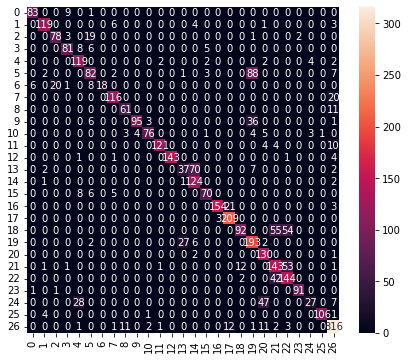

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        93
           1       0.92      0.89      0.91       133
           2       0.79      0.76      0.77       103
           3       0.85      0.81      0.83       100
           4       0.72      0.91      0.80       131
           5       0.63      0.44      0.52       185
           6       1.00      0.34      0.51        53
           7       0.89      0.85      0.87       136
           8       0.81      0.85      0.83        72
           9       0.96      0.67      0.79       141
          10       0.93      0.78      0.85        97
          11       0.97      0.87      0.92       139
          12       1.00      0.95      0.98       150
          13       0.56      0.31      0.40       118
          14       0.60      0.97      0.74       128
          15       0.86      0.79      0.82        89
          16       0.98      0.87      0.92       178
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\WONGCH~1\AppData\Local\Temp\tmp79zb244q\assets


7280

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.4326289e-04 3.2895776e-03 1.7106188e-03 9.5357515e-02 1.1077870e-01
 6.4923204e-02 4.9509888e-04 1.4267501e-01 3.8698199e-05 1.5621756e-02
 4.0906232e-02 8.0598344e-04 1.8329566e-04 1.3942729e-03 1.1768746e-03
 4.6127111e-01 5.7985715e-05 1.4470296e-05 4.9798389e-05 9.6963951e-04
 4.0550493e-03 6.3604544e-05 3.6645288e-05 2.7033866e-05 3.7595619e-02
 3.1864301e-03 1.2372552e-02]
15
